# Description

Here I do the same as the previous notebook, but with the GLS model proposed in PhenoPLIER.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "1000g_eur"
    / "covars"
    / "_corrs_5mb"
    / "gls-gtex_v8_mashr-sub_corr"
)
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr')

In [4]:
OUTPUT_DIR = conf.RESULTS["GLS_NULL_SIMS"]
display(OUTPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims')

In [5]:
PVALUE_COLUMN = "pvalue_onesided"

# Load MultiXcan genes present in results

In [6]:
_tmp = pd.read_csv(
    conf.RESULTS["GLS_NULL_SIMS"]
    / "twas"
    / "smultixcan"
    / "random.pheno0-gtex_v8-mashr-smultixcan.txt",
    sep="\t",
)

In [7]:
_tmp.shape

(22317, 18)

In [8]:
_tmp.head()

,gene,gene_name,pvalue,n,n_indep,p_i_best,t_i_best,p_i_worst,t_i_worst,eigen_max,eigen_min,eigen_min_kept,z_min,z_max,z_mean,z_sd,tmi,status
0,ENSG00000131941.7,RHPN2,0.000040,48.0,3.0,2.139470e-04,Artery_Tibial,0.990132,Brain_Nucleus_accumbens_basal_ganglia,36.556432,7.692089e-16,2.519701,-2.721185,3.701952,1.283152,1.825567,3.0,0
1,ENSG00000076650.6,GPATCH1,0.000078,40.0,3.0,4.534390e-04,Brain_Cerebellum,0.817384,Brain_Frontal_Cortex_BA9,29.990208,2.086487e-15,1.815203,-3.506853,2.383485,-2.016745,1.715495,3.0,0
2,ENSG00000100906.10,NFKBIA,0.000096,1.0,1.0,9.591208e-05,Brain_Frontal_Cortex_BA9,0.000096,Brain_Frontal_Cortex_BA9,1.000000,1.000000e+00,1.000000,-3.900707,-3.900707,-3.900707,NaN,1.0,0
3,ENSG00000136319.11,TTC5,0.000109,47.0,5.0,1.402826e-03,Brain_Hippocampus,0.961887,Colon_Sigmoid,21.272442,8.142339e-16,0.732606,-3.194069,1.397514,-0.916662,1.068989,5.0,0
4,ENSG00000152990.13,ADGRA3,0.000135,41.0,12.0,3.211289e-07,Heart_Atrial_Appendage,0.653657,Whole_Blood,12.988248,3.499412e-16,0.444682,-5.110605,3.599410,-0.464735,2.316607,12.0,0


In [9]:
multixcan_genes = set(_tmp["gene_name"])
display(len(multixcan_genes))
display(list(multixcan_genes)[:10])

22311

['SELP',
 'RP1-124C6.1',
 'IL23R',
 'ETNK2',
 'ARHGAP11A',
 'RP11-111H13.1',
 'GAD1',
 'RP11-230C9.4',
 'SPATA3',
 'RP5-860P4.2']

# Load MultiPLIER Z matrix

In [10]:
multiplier_z = pd.read_pickle(conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"])

In [11]:
multiplier_z.shape

(6750, 987)

In [12]:
# keep genes only present in MultiXcan
multiplier_z = multiplier_z.loc[
    sorted(multixcan_genes.intersection(multiplier_z.index))
]

In [13]:
multiplier_z.shape

(6446, 987)

In [14]:
multiplier_z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
A2M,0.000000,0.000000,0.000000,0.078428,0.0,0.00000,0.000000,0.046772,0.000000,0.011033,...,0.010910,0.000000,0.052869,0.012749,0.0,0.013982,0.152241,0.000000,0.000000,0.108884
AAAS,0.271162,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,1.513337,0.000000,...,0.000000,0.000000,0.000000,0.001385,0.0,0.000000,0.711896,0.030534,0.447105,0.424685
AANAT,0.005099,0.308497,0.028815,0.000000,0.0,0.00000,0.371725,0.000000,0.135238,0.000000,...,0.117163,0.018815,0.000000,0.193142,0.0,0.040401,0.180436,0.000000,0.000000,0.042064
AARS,0.512978,0.000000,0.451285,0.319568,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006208,0.021274,0.0,0.000000,0.062143,0.000000,0.000000,0.364892
AARS2,1.008157,0.000000,0.197424,0.024832,0.0,0.57081,0.000000,0.228675,0.000000,0.116243,...,0.000000,0.000000,0.153345,0.000000,0.0,0.000000,1.004578,0.014470,0.000000,0.000000


# Functions

In [15]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [16]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [17]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [18]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [19]:
def get_lv_genes(lv_code):
    lv_genes = multiplier_z[lv_code].sort_values(ascending=False)
    lv_obj = LVAnalysis(lv_code)
    return lv_obj.lv_genes.set_index("gene_name").loc[lv_genes.index]

# Get files list

In [20]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [21]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [22]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [23]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [24]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [25]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV136,0.395322,0.125894,3.140123,0.001696,0.000848,random.pheno988
1,LV175,0.331859,0.124790,2.659353,0.007849,0.003924,random.pheno988
2,LV116,0.337790,0.130191,2.594575,0.009492,0.004746,random.pheno988
3,LV585,0.323672,0.124886,2.591744,0.009571,0.004785,random.pheno988
4,LV816,0.322661,0.124720,2.587093,0.009701,0.004850,random.pheno988


In [26]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [27]:
_mt1e = show_prop(dfs)
display(_mt1e)

0.05578622087132725

# QQ-plot

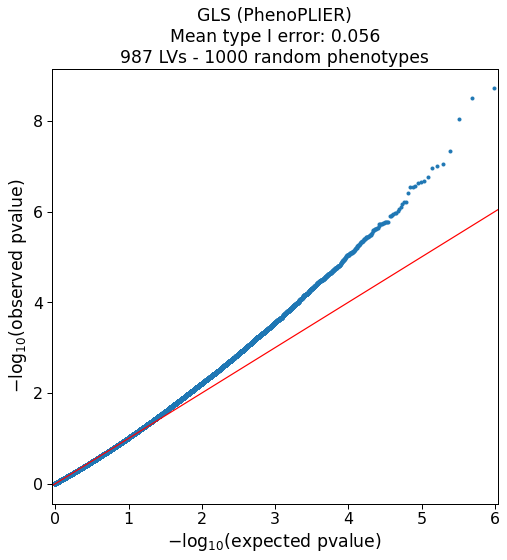

In [28]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(dfs[PVALUE_COLUMN])
    ax.set_title(
        f"GLS (PhenoPLIER)\nMean type I error: {_mt1e:.3f}\n{N_LVS} LVs - {N_PHENOTYPES} random phenotypes"
    )

# Summary of mean type I error per LV

In [29]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [30]:
summary_df.shape

(987, 4)

In [31]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.023,0.061
1,LV10,0.013,0.035,0.069
2,LV100,0.013,0.052,0.084
3,LV101,0.011,0.040,0.090
4,LV102,0.013,0.058,0.083


In [32]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.014775,0.055786,0.102652
std,0.005123,0.012673,0.018564
min,0.001000,0.016000,0.051000
25%,0.011000,0.047000,0.090000
50%,0.014000,0.056000,0.102000
75%,0.018000,0.063000,0.115000
max,0.035000,0.111000,0.176000


## LVs with expected type I error

In [33]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(89, 4)

,lv,1,5,10
561,LV604,0.015,0.049,0.099
384,LV445,0.011,0.049,0.081
843,LV859,0.016,0.049,0.087
450,LV504,0.011,0.049,0.093
838,LV854,0.016,0.049,0.087
821,LV839,0.018,0.049,0.091
819,LV837,0.018,0.049,0.091
507,LV556,0.013,0.049,0.097
544,LV59,0.016,0.049,0.088
774,LV797,0.014,0.049,0.090


,lv,1,5,10
62,LV155,0.009,0.051,0.089
90,LV180,0.018,0.051,0.112
128,LV214,0.010,0.051,0.105
191,LV271,0.013,0.051,0.107
212,LV290,0.018,0.051,0.099
300,LV37,0.012,0.051,0.097
324,LV391,0.013,0.051,0.097
722,LV75,0.014,0.051,0.114
356,LV42,0.009,0.051,0.104
414,LV472,0.015,0.051,0.095


## LVs with high type I error

In [34]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(330, 4)

,lv,1,5,10
310,LV379,0.024,0.083,0.125
369,LV431,0.022,0.084,0.137
253,LV327,0.026,0.085,0.132
672,LV704,0.018,0.085,0.149
341,LV406,0.019,0.086,0.133
752,LV777,0.021,0.086,0.156
151,LV235,0.029,0.087,0.138
946,LV951,0.025,0.088,0.157
975,LV978,0.022,0.088,0.148
892,LV902,0.028,0.088,0.138


## Save

In [35]:
summary_df[summary_df["5"] > 0.07]

,lv,1,5,10
5,LV103,0.020,0.073,0.117
10,LV108,0.021,0.080,0.144
22,LV119,0.014,0.072,0.119
33,LV129,0.026,0.071,0.112
38,LV133,0.022,0.074,0.128
...,...,...,...,...
962,LV966,0.024,0.072,0.126
972,LV975,0.020,0.072,0.133
975,LV978,0.022,0.088,0.148
980,LV982,0.020,0.082,0.146


In [36]:
summary_df.to_pickle(OUTPUT_DIR / "lvs-null_sims-1000g_eur-prop_type_I_errors.pkl")

# Query specific LVs

In [37]:
summary_df[summary_df["lv"].isin(("LV246", "LV603"))]

,lv,1,5,10
163,LV246,0.018,0.061,0.099
560,LV603,0.015,0.054,0.101


## LV246

In [38]:
lv_code = "LV246"

In [39]:
results = dfs[dfs["lv"] == lv_code]

In [40]:
results.shape

(1000, 7)

In [41]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
69,LV246,0.178002,0.125917,1.413648,0.157514,0.078757,random.pheno988
1440,LV246,-0.001120,0.126165,-0.008877,0.992917,0.503541,random.pheno589
2125,LV246,0.124476,0.126013,0.987807,0.323284,0.161642,random.pheno385
3127,LV246,0.116860,0.126023,0.927289,0.353812,0.176906,random.pheno5
4512,LV246,-0.032568,0.126154,-0.258162,0.796290,0.601855,random.pheno74


### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.018

In [43]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.061

In [44]:
show_prop(results, 0.10)

0.099

In [45]:
show_prop(results, 0.15)

0.153

In [46]:
show_prop(results, 0.20)

0.205

### QQplot

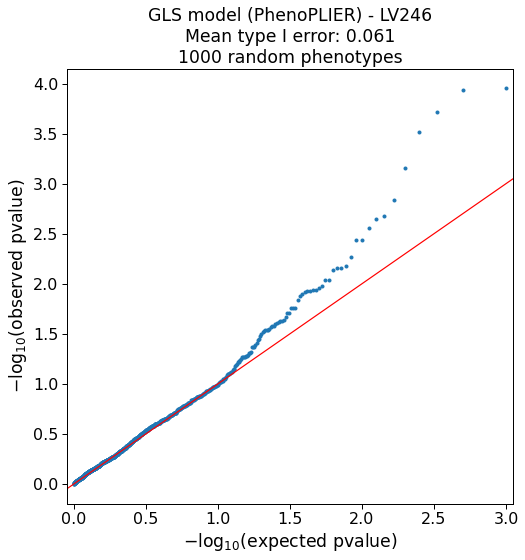

In [47]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

# Comparison with OLS model

## LVs with high mean type I error in OLS model

Here I compare the OLS's high mean type I error LVs with results from the GLS model.

### LV234

In [48]:
lv_code = "LV234"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
517,LV234,-0.027060,0.143899,-0.188050,0.850843,0.574578,random.pheno988
1872,LV234,-0.180468,0.144297,-1.250666,0.211102,0.894449,random.pheno589
2911,LV234,-0.219704,0.143922,-1.526549,0.126922,0.936539,random.pheno385
3636,LV234,-0.069257,0.144032,-0.480849,0.630640,0.684680,random.pheno5
4381,LV234,0.012264,0.144100,0.085110,0.932176,0.466088,random.pheno74


#### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.014

In [53]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.053

In [54]:
show_prop(results, 0.10)

0.09

In [55]:
show_prop(results, 0.15)

0.119

In [56]:
show_prop(results, 0.20)

0.16

#### QQplot

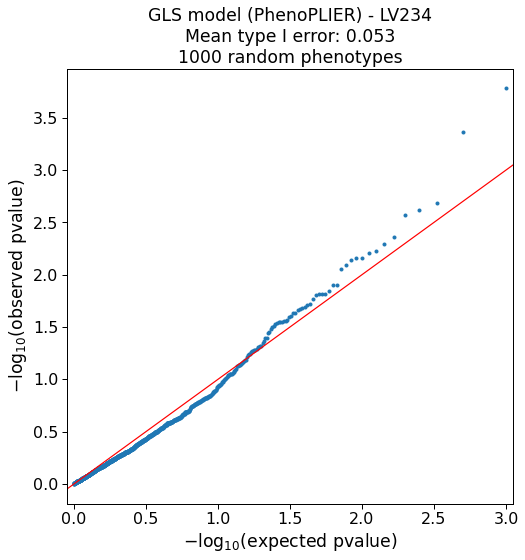

In [57]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

#### Top genes in LV

In [58]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV234,gene_band
HIST1H4E,7.379845,6p22.2
HIST1H3B,7.293635,6p22.2
HIST4H4,6.929394,12p12.3
HIST1H3H,6.863106,6p22.1
HIST1H3D,4.568047,6p22.2
HIST1H2BC,4.078396,6p22.2
HIST1H2AE,4.009782,6p22.2
HIST1H2BF,3.963254,6p22.2
HIST1H2BD,3.862981,6p22.2
HIST1H2BK,3.662444,6p22.1


In [59]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

6p22.2     17
6p22.1      5
7q11.23     3
16p11.2     2
15q23       2
9q31.3      2
12p12.3     1
1q42.12     1
18q11.2     1
1q32.2      1
Name: gene_band, dtype: int64

### LV847

In [60]:
lv_code = "LV847"

In [61]:
results = dfs[dfs["lv"] == lv_code]

In [62]:
results.shape

(1000, 7)

In [63]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
281,LV847,0.059926,0.141410,0.423774,0.671745,0.335872,random.pheno988
1531,LV847,-0.039309,0.141909,-0.276997,0.781791,0.609105,random.pheno589
2782,LV847,-0.127960,0.141503,-0.904293,0.365874,0.817063,random.pheno385
3419,LV847,0.011380,0.141580,0.080376,0.935941,0.467970,random.pheno5
4586,LV847,-0.061061,0.141656,-0.431054,0.666443,0.666778,random.pheno74


#### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.021

In [65]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.066

In [66]:
show_prop(results, 0.10)

0.125

In [67]:
show_prop(results, 0.15)

0.19

In [68]:
show_prop(results, 0.20)

0.236

#### QQplot

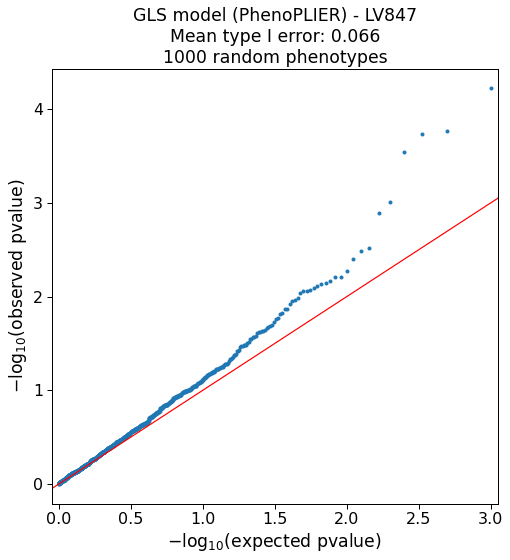

In [69]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

#### Top genes in LV

In [70]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV847,gene_band
HIST1H3D,6.805370,6p22.2
HIST1H3H,6.276783,6p22.1
HIST1H3B,6.099625,6p22.2
HIST1H4E,5.971181,6p22.2
HIST4H4,5.431832,12p12.3
HIST1H2BH,5.150647,6p22.2
HIST1H2AE,4.324334,6p22.2
HIST1H2BN,4.269944,6p22.1
HIST1H2BE,4.258760,6p22.2
HIST1H2AC,4.046811,6p22.2


In [71]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

6p22.2      15
6p22.1       5
15q26.1      2
11q23.3      2
19p13.3      2
12p12.3      2
3q13.33      2
18q11.2      2
20q13.12     2
12p13.31     2
Name: gene_band, dtype: int64

### LV45

In [72]:
lv_code = "LV45"

In [73]:
results = dfs[dfs["lv"] == lv_code]

In [74]:
results.shape

(1000, 7)

In [75]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
941,LV45,-0.234276,0.141205,-1.659120,0.097140,0.951430,random.pheno988
1244,LV45,0.078323,0.141696,0.552755,0.580450,0.290225,random.pheno589
2167,LV45,0.120872,0.141316,0.855331,0.392400,0.196200,random.pheno385
3546,LV45,-0.036517,0.141363,-0.258317,0.796170,0.601915,random.pheno5
4425,LV45,-0.009052,0.141440,-0.064001,0.948971,0.525514,random.pheno74


#### Mean type I errors at different thresholds

In [76]:
show_prop(results, 0.01)

0.012

In [77]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.069

In [78]:
show_prop(results, 0.10)

0.131

In [79]:
show_prop(results, 0.15)

0.184

In [80]:
show_prop(results, 0.20)

0.23

#### QQplot

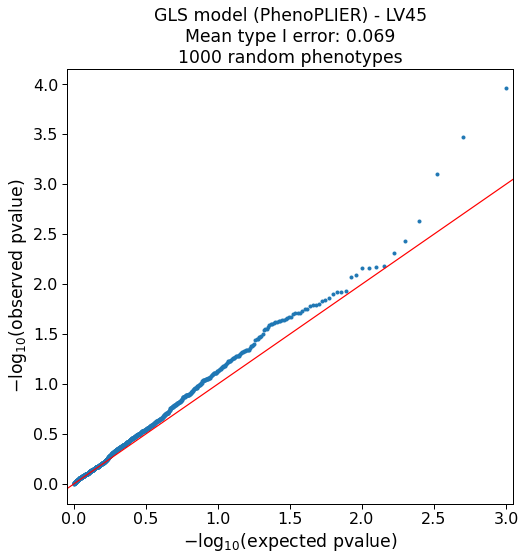

In [81]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

#### Top genes in LV

In [82]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV45,gene_band
HIST1H2BO,8.480948,6p22.1
HIST1H2BF,8.426226,6p22.2
HIST1H2BK,8.245903,6p22.1
HIST1H2BD,8.119013,6p22.2
HIST1H2BC,7.744137,6p22.2
HIST1H2AC,7.447932,6p22.2
HIST2H2BF,6.700409,1q21.2
HIST1H2AG,6.405812,6p22.1
HIST1H2BN,5.913649,6p22.1
HIST1H2AE,5.898213,6p22.2


In [83]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

6p22.2      12
6p22.1       6
1q23.3       3
6p21.33      2
2p23.3       2
12p13.31     2
1q42.13      2
1q21.2       2
3q13.33      2
16q22.1      2
Name: gene_band, dtype: int64

### LV800

In [84]:
lv_code = "LV800"

In [85]:
results = dfs[dfs["lv"] == lv_code]

In [86]:
results.shape

(1000, 7)

In [87]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
96,LV800,0.185413,0.149104,1.243509,0.213726,0.106863,random.pheno988
1408,LV800,0.014917,0.149358,0.099875,0.920447,0.460223,random.pheno589
2801,LV800,-0.142208,0.149151,-0.953449,0.340398,0.829801,random.pheno385
3695,LV800,-0.094337,0.149155,-0.632475,0.527099,0.736451,random.pheno5
4373,LV800,0.016381,0.149319,0.109704,0.912648,0.456324,random.pheno74


#### Mean type I errors at different thresholds

In [88]:
show_prop(results, 0.01)

0.023

In [89]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.07

In [90]:
show_prop(results, 0.10)

0.115

In [91]:
show_prop(results, 0.15)

0.158

In [92]:
show_prop(results, 0.20)

0.207

#### QQplot

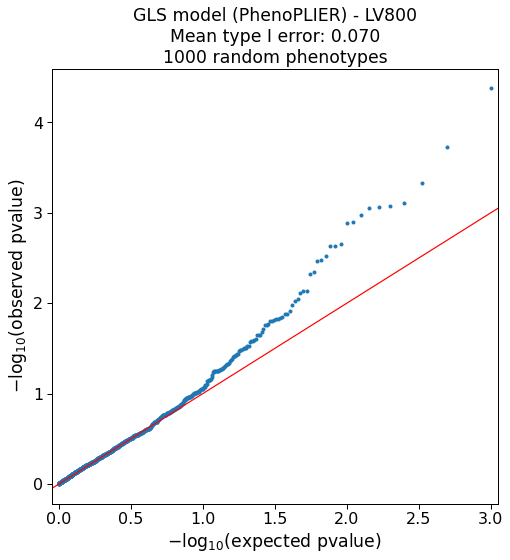

In [93]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

#### Top genes in LV

In [94]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV800,gene_band
ZNF20,1.980700,19p13.2
ZNF606,1.931659,19q13.43
ZNF551,1.832833,19q13.43
ZNF543,1.701683,19q13.43
ZNF14,1.640789,19p13.11
ZNF625,1.612766,19p13.2
ZNF234,1.608893,19q13.31
ZNF468,1.601126,19q13.41
ZFP28,1.591189,19q13.43
ZNF485,1.586159,10q11.21


In [95]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

19q13.43    16
19p13.2      9
19q13.31     9
19q13.41     8
19q13.12     4
19p12        2
1p36.22      1
5q35.3       1
10q21.1      1
4p16.3       1
Name: gene_band, dtype: int64

### LV914

This one is not corrected here, I analyze it below.

### LV189

In [96]:
lv_code = "LV189"

In [97]:
results = dfs[dfs["lv"] == lv_code]

In [98]:
results.shape

(1000, 7)

In [99]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
930,LV189,-0.209546,0.135260,-1.549211,0.121380,0.939310,random.pheno988
1060,LV189,0.190038,0.135507,1.402420,0.160838,0.080419,random.pheno589
2301,LV189,0.050078,0.135301,0.370127,0.711300,0.355650,random.pheno385
3348,LV189,0.038358,0.135376,0.283346,0.776921,0.388460,random.pheno5
4364,LV189,0.016850,0.135361,0.124484,0.900936,0.450468,random.pheno74


#### Mean type I errors at different thresholds

In [100]:
show_prop(results, 0.01)

0.024

In [101]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.077

In [102]:
show_prop(results, 0.10)

0.131

In [103]:
show_prop(results, 0.15)

0.188

In [104]:
show_prop(results, 0.20)

0.233

#### QQplot

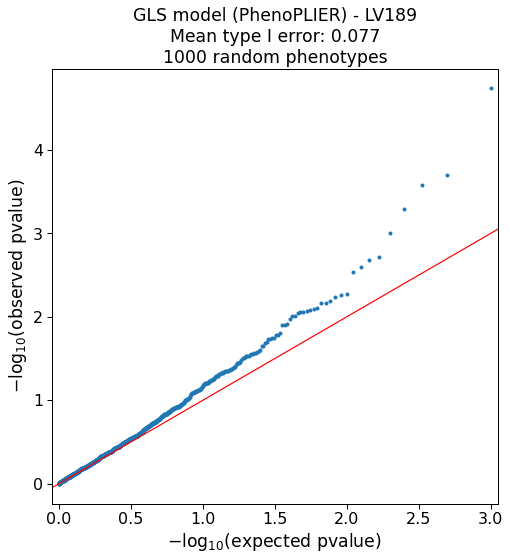

In [105]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

#### Top genes in LV

In [106]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV189,gene_band
TCN1,7.445036,11q12.1
ALDH3B2,4.980042,11q13.2
MED1,4.384997,17q12
PSMD3,4.113116,17q21.1
CDK12,2.875934,17q12
PIP4K2B,2.794035,17q12
ERBB2,2.676997,17q12
MED24,2.188042,17q21.1
PIGO,1.995728,9p13.3
ACACA,1.773115,17q12


In [107]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

17q12       10
20q11.22     6
17q22        4
9p13.3       3
11q13.2      3
11q13.4      3
17q21.1      2
20q13.32     2
2p25.1       2
20q13.13     2
Name: gene_band, dtype: int64

## LVs with expected mean type I error

Here I make sure the well calibrated LVs in the OLS model are still well calibrated here.

In [108]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
561,LV604,0.015,0.049,0.099
384,LV445,0.011,0.049,0.081
843,LV859,0.016,0.049,0.087
450,LV504,0.011,0.049,0.093
838,LV854,0.016,0.049,0.087
821,LV839,0.018,0.049,0.091
819,LV837,0.018,0.049,0.091
507,LV556,0.013,0.049,0.097
544,LV59,0.016,0.049,0.088
774,LV797,0.014,0.049,0.090


Here I'm manually selecting from this list, since I want those that are well calibrated across different p-value thresholds.

### LV924

In [109]:
lv_code = "LV924"

In [110]:
results = dfs[dfs["lv"] == lv_code]

In [111]:
results.shape

(1000, 7)

In [112]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
519,LV924,-0.024441,0.125578,-0.194628,0.845690,0.577155,random.pheno988
1673,LV924,-0.080250,0.125793,-0.637951,0.523528,0.738236,random.pheno589
2507,LV924,-0.013435,0.125659,-0.106917,0.914858,0.542571,random.pheno385
3343,LV924,0.036890,0.125694,0.293494,0.769154,0.384577,random.pheno5
4927,LV924,-0.276493,0.125739,-2.198937,0.027918,0.986041,random.pheno74


#### Mean type I errors at different thresholds

In [113]:
show_prop(results, 0.01)

0.009

In [114]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.044

In [115]:
show_prop(results, 0.10)

0.093

In [116]:
show_prop(results, 0.15)

0.141

In [117]:
show_prop(results, 0.20)

0.177

#### QQplot

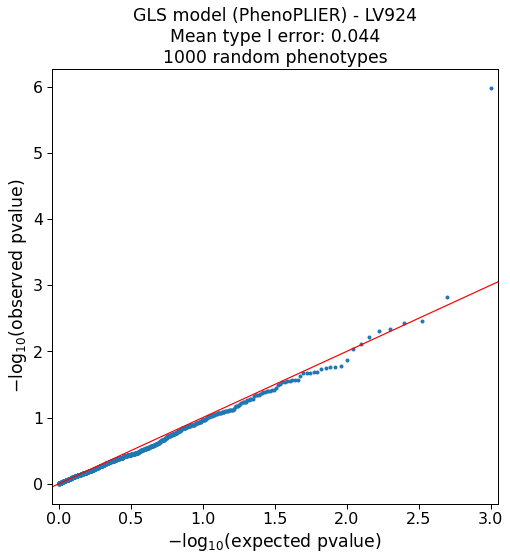

In [118]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

Hm, well calibrated in general, but with one small pvalue.

### LV675

In [119]:
lv_code = "LV675"

In [120]:
results = dfs[dfs["lv"] == lv_code]

In [121]:
results.shape

(1000, 7)

In [122]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
928,LV675,-0.193104,0.125043,-1.544298,0.122565,0.938717,random.pheno988
1436,LV675,0.001455,0.125293,0.011611,0.990736,0.495368,random.pheno589
2171,LV675,0.103375,0.125144,0.826047,0.408808,0.204404,random.pheno385
3783,LV675,-0.111620,0.125150,-0.891892,0.372484,0.813758,random.pheno5
4342,LV675,0.020663,0.125272,0.164945,0.868993,0.434496,random.pheno74


#### Mean type I errors at different thresholds

In [123]:
show_prop(results, 0.01)

0.011

In [124]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.05

In [125]:
show_prop(results, 0.10)

0.099

In [126]:
show_prop(results, 0.15)

0.144

In [127]:
show_prop(results, 0.20)

0.197

#### QQplot

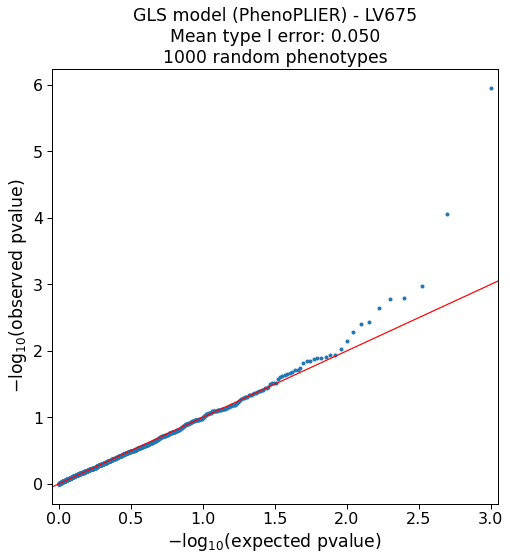

In [128]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### LV691

In [129]:
lv_code = "LV691"

In [130]:
results = dfs[dfs["lv"] == lv_code]

In [131]:
results.shape

(1000, 7)

In [132]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
95,LV691,0.155260,0.124764,1.244426,0.213388,0.106694,random.pheno988
1852,LV691,-0.145087,0.124994,-1.160754,0.245785,0.877107,random.pheno589
2318,LV691,0.040526,0.124863,0.324567,0.745520,0.372760,random.pheno385
3199,LV691,0.087870,0.124864,0.703722,0.481631,0.240816,random.pheno5
4123,LV691,0.114576,0.124983,0.916737,0.359315,0.179657,random.pheno74


#### Mean type I errors at different thresholds

In [133]:
show_prop(results, 0.01)

0.013

In [134]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.048

In [135]:
show_prop(results, 0.10)

0.099

In [136]:
show_prop(results, 0.15)

0.157

In [137]:
show_prop(results, 0.20)

0.2

#### QQplot

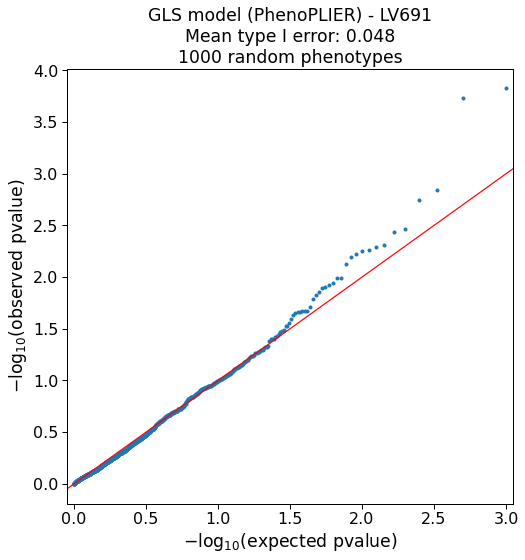

In [138]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

# GLS model - LVs with high mean type I error

## LV914

In [139]:
lv_code = "LV914"

In [140]:
results = dfs[dfs["lv"] == lv_code]

In [141]:
results.shape

(1000, 7)

In [142]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
73,LV914,0.176873,0.126381,1.399524,0.161704,0.080852,random.pheno988
1523,LV914,-0.031575,0.126573,-0.249464,0.803010,0.598495,random.pheno589
2781,LV914,-0.114039,0.126520,-0.901347,0.367438,0.816281,random.pheno385
3403,LV914,0.015361,0.126448,0.121479,0.903316,0.451658,random.pheno5
4535,LV914,-0.039077,0.126561,-0.308758,0.757516,0.621242,random.pheno74


### Mean type I errors at different thresholds

In [143]:
show_prop(results, 0.01)

0.035

In [144]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.111

In [145]:
show_prop(results, 0.10)

0.176

In [146]:
show_prop(results, 0.15)

0.236

In [147]:
show_prop(results, 0.20)

0.298

### QQplot

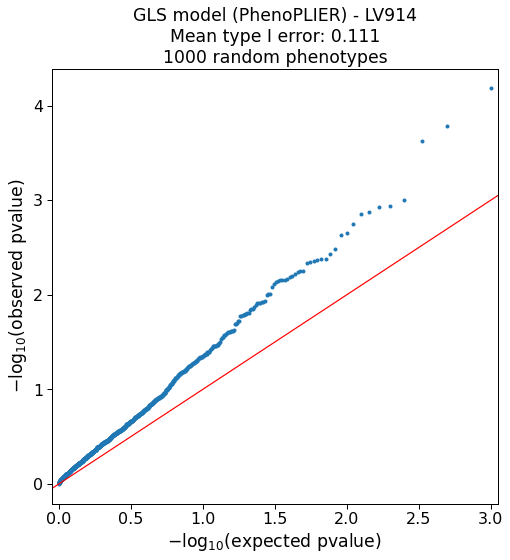

In [148]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [149]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV914,gene_band
IL23A,6.258103,12q13.3
AKT2,5.248118,19q13.2
HOXA5,2.588375,7p15.2
LAMA2,2.255515,6q22.33
RNF8,1.722023,6p21.2
PAPOLG,1.398173,2p16.1
MBD4,1.376868,3q21.3
TBK1,1.328314,12q14.2
CBLB,1.305683,3q13.11
DOK1,1.219439,2p13.1


In [150]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

13q13.3     2
7p15.2      2
19q13.2     2
3q25.33     1
2q35        1
19q13.33    1
12q13.11    1
19q13.32    1
6p22.3      1
8q13.3      1
Name: gene_band, dtype: int64

## LV816

In [151]:
lv_code = "LV816"

In [152]:
results = dfs[dfs["lv"] == lv_code]

In [153]:
results.shape

(1000, 7)

In [154]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
4,LV816,0.322661,0.124720,2.587093,0.009701,0.004850,random.pheno988
1176,LV816,0.100374,0.125006,0.802954,0.422031,0.211016,random.pheno589
2703,LV816,-0.080575,0.124865,-0.645293,0.518760,0.740620,random.pheno385
3601,LV816,-0.046919,0.124873,-0.375733,0.707128,0.646436,random.pheno5
3997,LV816,0.203803,0.124971,1.630805,0.102980,0.051490,random.pheno74


### Mean type I errors at different thresholds

In [155]:
show_prop(results, 0.01)

0.033

In [156]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.103

In [157]:
show_prop(results, 0.10)

0.155

In [158]:
show_prop(results, 0.15)

0.222

In [159]:
show_prop(results, 0.20)

0.266

### QQplot

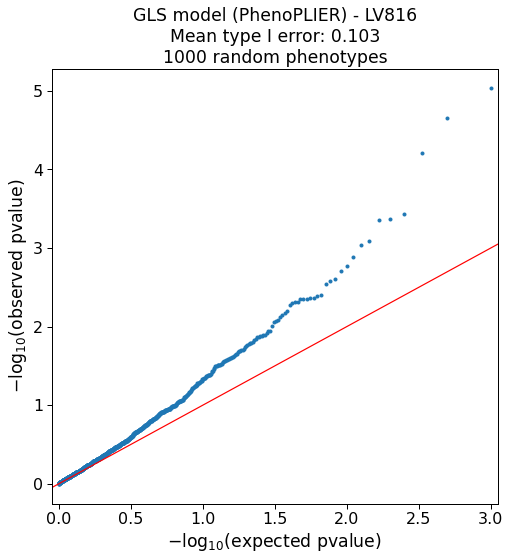

In [160]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [161]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV816,gene_band
ATP1B2,5.753339,17p13.1
PON2,4.335049,7q21.3
ALDOC,4.301768,17q11.2
GLUD1,3.721127,10q23.2
GJB6,3.628673,13q12.11
CLDN10,3.373320,13q32.1
SLC15A2,3.123544,3q13.33
GLUL,3.063349,1q25.3
SLC4A4,3.023711,4q13.3
SLC48A1,2.848704,12q13.11


In [162]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

17q11.2     2
17p13.1     2
14q24.3     1
11p15.4     1
17p12       1
11p15.1     1
5q31.2      1
14q32.33    1
19q13.33    1
8q13.1      1
Name: gene_band, dtype: int64

## LV588

In [163]:
lv_code = "LV588"

In [164]:
results = dfs[dfs["lv"] == lv_code]

In [165]:
results.shape

(1000, 7)

In [166]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
881,LV588,-0.157796,0.124794,-1.264446,0.206116,0.896942,random.pheno988
1057,LV588,0.180823,0.125016,1.446396,0.148115,0.074057,random.pheno589
2372,LV588,0.026020,0.124894,0.208334,0.834975,0.417487,random.pheno385
3926,LV588,-0.228049,0.124867,-1.826342,0.067845,0.966077,random.pheno5
4184,LV588,0.081962,0.125018,0.655603,0.512103,0.256051,random.pheno74


### Mean type I errors at different thresholds

In [167]:
show_prop(results, 0.01)

0.017

In [168]:
_mt1e = show_prop(results, 0.05)
display(_mt1e)

0.095

In [169]:
show_prop(results, 0.10)

0.155

In [170]:
show_prop(results, 0.15)

0.216

In [171]:
show_prop(results, 0.20)

0.275

### QQplot

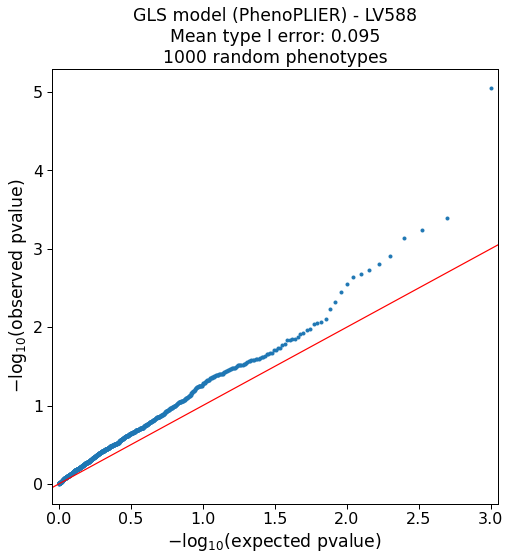

In [172]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(results[PVALUE_COLUMN])
    ax.set_title(
        f"GLS model (PhenoPLIER) - {lv_code}\nMean type I error: {_mt1e:.3f}\n{results.shape[0]} random phenotypes"
    )

### Top genes in LV

In [173]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV588,gene_band
ASB8,4.260123,12q13.11
PEX1,3.746568,7q21.2
BLOC1S3,3.451845,19q13.32
VLDLR,3.393852,9p24.2
ATP8A2,2.129880,13q12.13
SLC7A6,2.108679,16q22.1
MFN1,2.061924,3q26.33
ZMYM2,2.055472,13q12.11
DAAM1,1.960115,14q23.1
CES3,1.888471,16q22.1


In [174]:
# see bands of top genes
lv_genes.head(68)["gene_band"].value_counts().head(10)

8p23.1      2
7q21.2      2
10q26.13    2
16q22.1     2
4q21.1      2
1p35.3      1
11q21       1
3q13.2      1
1p31.1      1
2q23.1      1
Name: gene_band, dtype: int64

# Conclusions

The GLS model is definitely an improvement over the OLS model:

* It corrects LVs with top genes from the same band, like LV234, LV847, LV45.
* There is a small improvement on mean type I error (0.0584 vs 0.0557).

However, it does not fix other problematic LVs, like LV914.